In [1]:
from SimPEG import Mesh, Utils, EM, Maps
from pymatsolver import Pardiso
from scipy.constants import mu_0
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pyMKL import mkl_set_num_threads
from multiprocessing import Pool
from SimPEG import Mesh
from simpegskytem import ProblemSkyTEM, GlobalAEMSurveyTD, GlobalSkyTEM, get_skytem_survey
import pandas as pd
from scipy.interpolate import NearestNDInterpolator

In [2]:
from simpegskytem import Utils

In [3]:
mesh, models = Mesh.TensorMesh.read_vtk('./data/models.vtr')
dem = pd.read_csv("./data/topo.csv").values

In [4]:
unit_conversion = 1e-12

i_start_hm = 10
i_start_lm = 10

waveform_hm_312 = np.loadtxt("./data/waveform_hm_312.txt")
waveform_lm_312 = np.loadtxt("./data/waveform_lm_312.txt")
time_input_currents_hm_312 = waveform_hm_312[:,0] 
input_currents_hm_312 = waveform_hm_312[:,1]
time_input_currents_lm_312 = waveform_lm_312[:,0] 
input_currents_lm_312 = waveform_lm_312[:,1]

time_gates = np.loadtxt("./data/time_gates")
GateTimeShift=-2.09E-06
MeaTimeDelay=0.000E+00
NoGates=28
t0_lm_312 = waveform_lm_312[:,0].max()
times_lm_312 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_lm:] - t0_lm_312

GateTimeShift=-1.5E-06
MeaTimeDelay=3.500E-04
NoGates=37
t0_hm_312 = waveform_hm_312[:,0].max()
times_hm_312 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_hm:] - t0_hm_312    

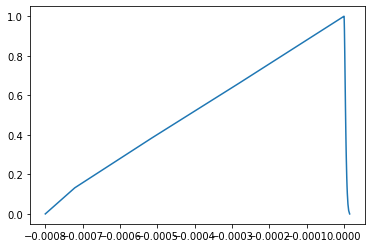

In [5]:
plt.plot(time_input_currents_lm_312, input_currents_lm_312)

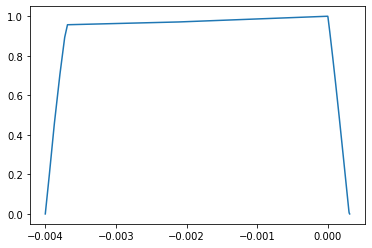

In [6]:
plt.plot(time_input_currents_hm_312, input_currents_hm_312)

In [7]:
rho = models['resistivity']
active_inds = models['active_inds']
actv = models['actv'].astype(bool)

In [8]:
tmp = rho.copy()
tmp[~active_inds.astype(bool)] = np.nan

In [9]:
# mesh.plotSlice(actv, clim=(0, 1), normal='x')

In [10]:
xmin, xmax = 716671.86738603, 765008.0956554-11000
ymin, ymax = 3927835.39503287, 3956784.32173684
# generate survey
x_inds = np.argwhere(np.logical_and(mesh.vectorCCx > xmin, mesh.vectorCCx < xmax))
y_inds = np.argwhere(np.logical_and(mesh.vectorCCy > ymin, mesh.vectorCCy < ymax))
x = mesh.vectorCCx[x_inds]
y = mesh.vectorCCy[y_inds]
f_dem = NearestNDInterpolator(dem[:,:2], dem[:,2])
xy = Utils.ndgrid(x, y)
src_height = 30.
z = f_dem(xy)
src_locations = np.c_[xy, z + src_height]
rx_locations = np.c_[xy[:,0]+13.25, xy[:,1], z+2.+ src_height]
topo = np.c_[xy, z]
n_sounding = src_locations.shape[0]

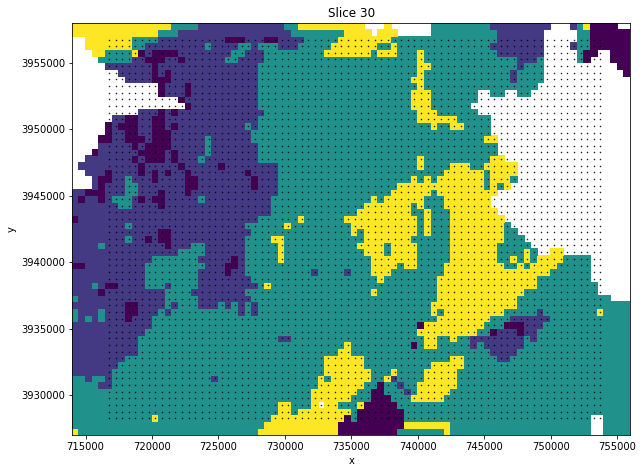

In [11]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
mesh.plotSlice(tmp, clim=(10, 40), ind=30, ax=ax)
ax.plot(src_locations[:,0], src_locations[:,1], 'k.', ms=1)
ax.set_aspect(1)

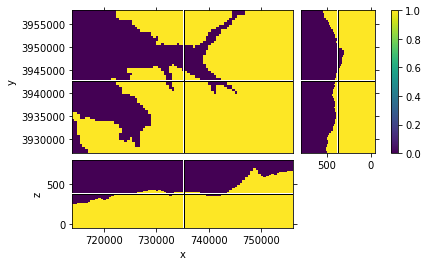

In [12]:
mesh.plot_3d_slicer(
    actv, clim=(0, 1)
)

In [13]:
survey = get_skytem_survey(
    topo,
    src_locations,
    rx_locations,
    times_hm_312,
    time_input_currents_hm_312,
    input_currents_hm_312,
    25.,
    src_type="VMD",
    rx_type="dBzdt",    
    moment_type="dual",        
    time_dual_moment=times_lm_312,
    time_input_currents_dual_moment=time_input_currents_lm_312,
    input_currents_dual_moment=input_currents_lm_312,
    base_frequency_dual_moment=210.,
    wave_type="general",    
    field_type="secondary",    
)

simulation = GlobalSkyTEM(
    mesh, 
    sigma=1./rho, 
    actv=actv, 
    parallel_option='multiprocess'
)
simulation.pair(survey)

>> Set parameters


In [14]:
print (survey.n_sounding)

4350


In [ ]:
# write inputs to the disk
simulation.write_inputs_on_disk_pool()

In [100]:
%time data = simulation.forward(1./rho)

CPU times: user 2.5 s, sys: 1.05 s, total: 3.55 s
Wall time: 15min 10s


In [17]:
np.save('./data/data', data)

In [19]:
DATA = data.reshape((times_hm_312.size+times_lm_312.size, n_sounding), order='F')

In [58]:
DATA_HM = -DATA[:times_hm_312.size,:]
DATA_LM = -DATA[times_hm_312.size:,:]

(<matplotlib.contour.QuadContourSet at 0x2afbbbc03290>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2afbbb91cb50>)

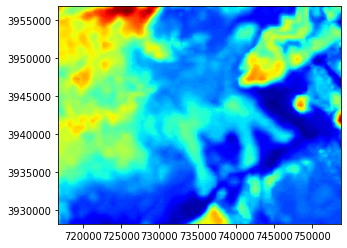

In [114]:
i_time = 25
Utils.plot2Ddata(xy, np.log10(DATA_HM[i_time,:]), ncontour=100, contourOpts={'cmap':'jet'})

(<matplotlib.contour.QuadContourSet at 0x2afbadc6ffd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2afbae3845d0>)

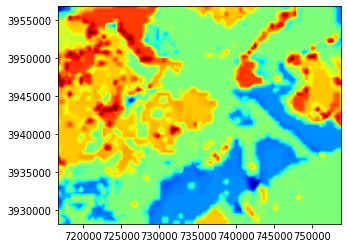

In [99]:
i_time = 0
Utils.plot2Ddata(xy, np.log10(DATA_LM[i_time,:]), ncontour=100, contourOpts={'cmap':'jet'})

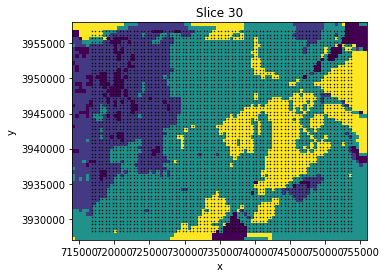

In [96]:
ax = plt.gca()
mesh.plotSlice(rho, clim=(10, 40), ind=30, ax=ax)
ax.plot(src_locations[:,0], src_locations[:,1], 'k.', ms=1)
ax.set_aspect(1)

In [56]:
DATA_HM[i_time,:].min()

-2.81075978561649e-13

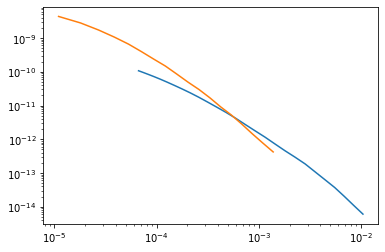

In [78]:
i_sounding = 0
plt.loglog(times_hm_312, DATA_HM[:,i_sounding])
plt.loglog(times_lm_312, DATA_LM[:,i_sounding])

In [104]:
# df = pd.DataFrame(data=topo, columns=['X', 'Y', 'Z'])

In [108]:
# df.to_csv('./data/skytem-topo.csv', index=False)

In [109]:
import pyvista as pv
poly = pv.PolyData(topo)
poly.save('./data/skytem-topo.vtk')